# Imports

In [12]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt

# Load the Image

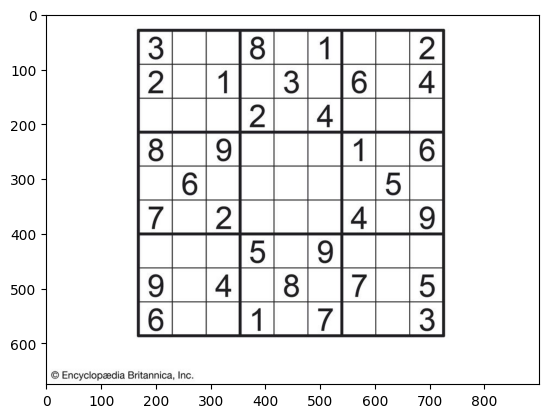

In [13]:
#req = urllib.request.urlopen('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSXWgbXAGTp-igspDP1qDo3aFJeE4vd_2u3Og&usqp=CAU')
#req = urllib.request.urlopen('https://live.staticflickr.com/8027/6978422072_33ac92fe1a_b.jpg')
#req = urllib.request.urlopen('https://jump.dev/JuMP.jl/stable/assets/partial_sudoku.png')
# req = urllib.request.urlopen('https://sources.roboflow.com/dcbM99GUgvVCEMo4F2rq8vaVApB2/DSJGI2e7g77XqctWIGQG/original.jpg')
# req = urllib.request.urlopen('https://cdn.britannica.com/42/97142-131-E3E24AA5/sudoku-puzzle-games.jpg')
req = urllib.request.urlopen('https://cdn.britannica.com/42/97142-131-E3E24AA5/sudoku-puzzle-games.jpg')

arr = np.asarray(bytearray(req.read()), dtype=np.uint8) #transform image to array
img = cv2.imdecode(arr, -1) # 'Load it as it is'
plt.imshow(img, cmap="gray")

# Convert to Grayscale

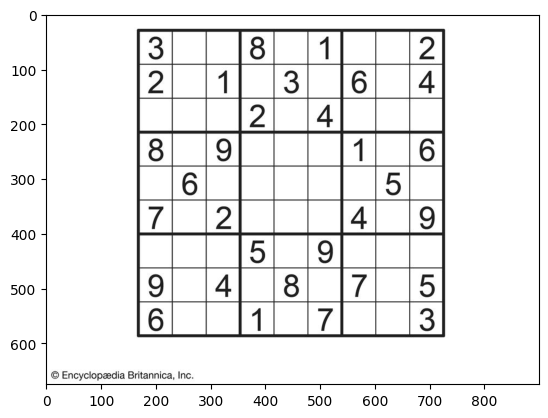

In [14]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image, cmap="gray") 

# Remove Noise using a 3x3 Gaussian Filter

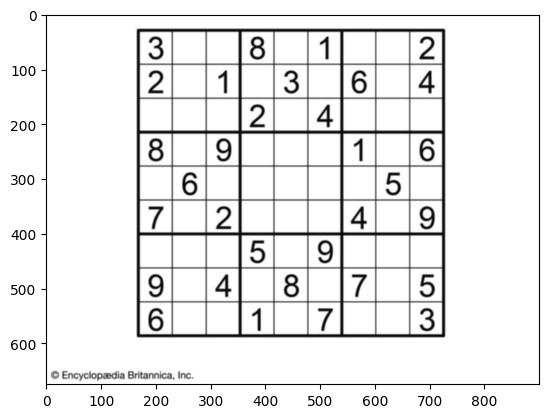

In [15]:
blurred = cv2.GaussianBlur(gray_image, (3, 3), cv2.BORDER_DEFAULT)
plt.imshow(blurred, cmap="gray")

# Adaptive Thresholding

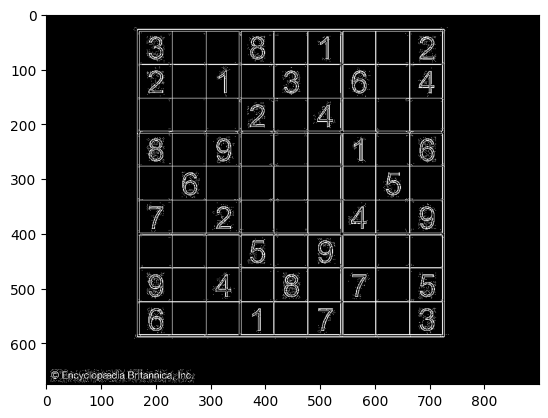

In [16]:
img_gray_threshed = cv2.adaptiveThreshold(src=gray_image,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=3,
    C=5
)
plt.imshow(img_gray_threshed, cmap="gray")

# Get the largest object in the image using Cotours
## *It is assumed that the sudoku frame is the largest object in the image*

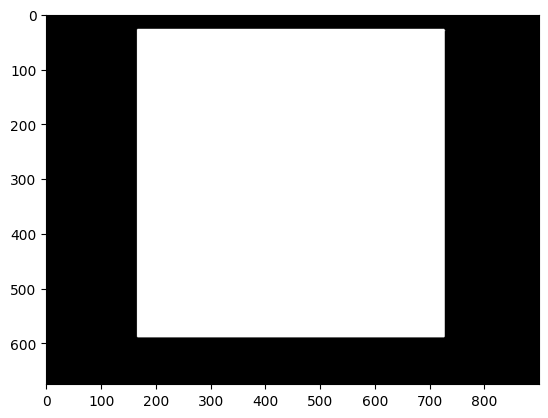

In [29]:

max = -1
x = -1
contours, _ = cv2.findContours(img_gray_threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
selected_contours = []
sudoku_square = np.zeros(img_gray_threshed.shape, np.uint8)
for i in range(len(contours)):
  area = cv2.contourArea(contours[i])
  if area > max:
     max = area
     x = i   

selected_contours.append(contours[x])
cv2.fillPoly(sudoku_square, pts=selected_contours, color= (255,255,255))
plt.imshow(sudoku_square, cmap="gray")



# Extract Edges using Canny

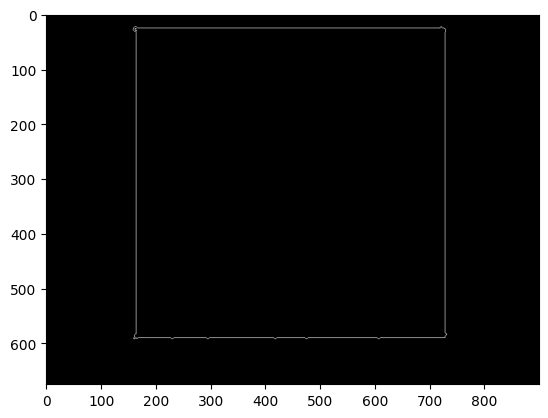

In [20]:
canny_img = cv2.Canny(sudoku_square, 50, 150)
plt.imshow(canny_img, cmap="gray")

# Remove Connected Components

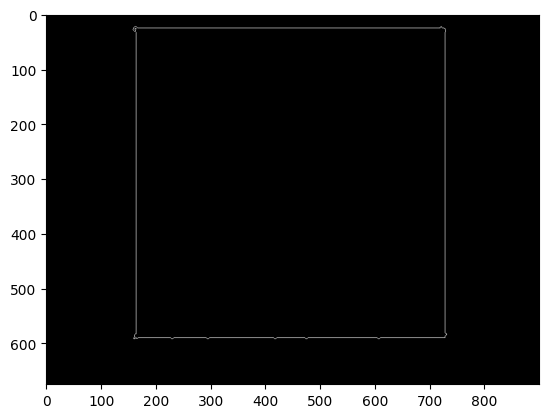

In [21]:
analysis = cv2.connectedComponentsWithStats(canny_img, 
                                            4, 
                                            cv2.CV_32S) 
(totalLabels, label_ids, values, centroid) = analysis 

output = np.zeros(gray_image.shape, dtype="uint8") 
  
for i in range(1, totalLabels): 
    # Area of the component 
    area = values[i, cv2.CC_STAT_AREA]  
      
    if (area > 400): 
        componentMask = (label_ids == i).astype("uint8") * 255
        output = cv2.bitwise_or(output, componentMask) 

plt.imshow(output, cmap="gray")

# Get the corners using Harris

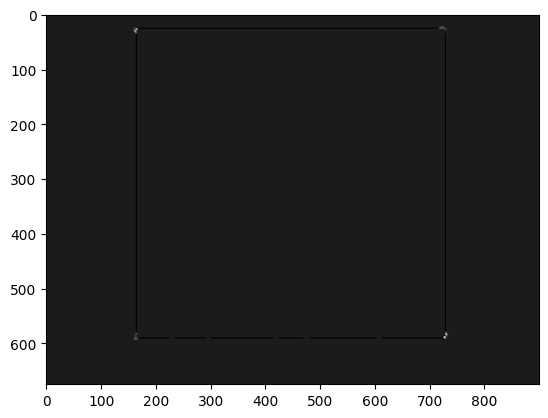

In [23]:
dest = cv2.cornerHarris(output, 2, 3, 0.05) 
  
# Results are marked through the dilated corners 
dest = cv2.dilate(dest, None) 
  
# Reverting back to the original image, 
# with optimal threshold value 

plt.imshow(dest, cmap="gray")

# Apply a Gaussian Filter, get the absolute values, then Threshhold to only get the corner points

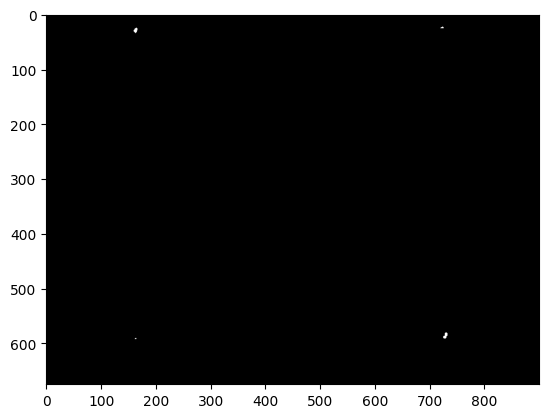

In [28]:
Gaussian_box = cv2.GaussianBlur(dest,(7,7), 0)
#plt.imshow(Gaussian_box, cmap='gray');
Gaussian_box = np.abs(Gaussian_box)
#plt.imshow(Gaussian_box, cmap='gray');

# for i in range(Gaussian_box.shape[0]):
#     for j in range(Gaussian_box.shape[1]):
#         if Gaussian_box[i][j] > 0:
#             print(Gaussian_box[i][j])
ret, thresh1 = cv2.threshold(Gaussian_box, 0.02, 255, cv2.THRESH_BINARY) 

plt.imshow(thresh1, cmap='gray')

# Get the coordinates of the Corners

In [26]:
x = np.zeros((1000))
y = np.zeros((1000))

for i in range(1000):
    x[i] = 99999
    y[i] = 99999


count = 0
# print(thresh1.shape)
for i in range(thresh1.shape[0]):
    for j in range(thresh1.shape[1]):
        if thresh1[i][j] == 255:
            x[count] = j
            y[count] = i
            count += 1
            


# print(x)
# print(y)

maxX = np.max(x)
maxY = np.max(y)
minX = np.min(x)
minY = np.min(y)

x1, y1 = minX, minY
x2, y2 = maxX, minY
x3, y3 = minX, maxY
x4, y4 = maxX, maxY

c1 = [x1, y1]
c2 = [x2, y2]
c3 = [x3, y3]
c4 = [x4, y4]

print(c1)
print(c2)
print(c3)
print(c4)

[160.0, 23.0]
[99999.0, 23.0]
[160.0, 99999.0]
[99999.0, 99999.0]


# Perspective Transform

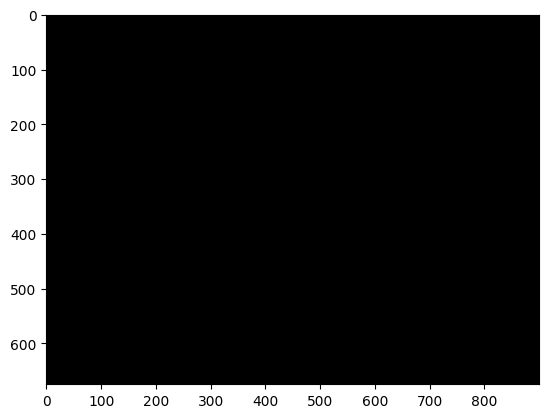

In [27]:
y, x = img_gray_threshed.shape
src_coords = np.float32([[0,0], [x,0], [x,y], [0,y]])
dst_coords = np.float32([[c1[::-1], c2[::-1], c4[::-1], c3[::-1]]])
img_gray_threshed_warped = cv2.warpPerspective(
    src=img_gray_threshed,
    M=cv2.getPerspectiveTransform(dst_coords, src_coords),
    dsize=img_gray_threshed.shape[::-1]
)
plt.imshow(img_gray_threshed_warped, cmap="gray");
# pts1 = np.float32([c1[::-1], c2[::-1],
#                        c3[::-1], c4[::-1]])
# # pts2 = np.float32([[0, 0], [400, 0],
#                       # [0, 640], [400, 640]])
     
# # Apply Perspective Transform Algorithm
# matrix = cv2.getPerspectiveTransform(pts1, src_coords)
# result = cv2.warpPerspective(img_gray_threshed, matrix, img_gray_threshed.shape)

# plt.imshow(result, cmap='gray')